# Titanic Challenge

In [97]:
t_train_orig = pd.read_csv("../data/raw/train.csv")
t_train_orig.name = "Titanic Training Set"
t_test_orig = pd.read_csv("../data/raw/test.csv")
t_test_orig.name = "Titanic Test Set"

###  Women were much more likely to survive than men

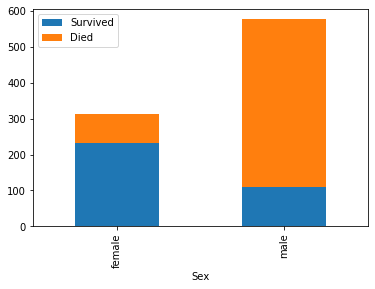

In [98]:
t_train_orig['Died']= t_train_orig['Survived'].map(lambda survived: 0 if survived == 1 else 1)
t_train_orig.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true')

### Higher fare improves chance of survival

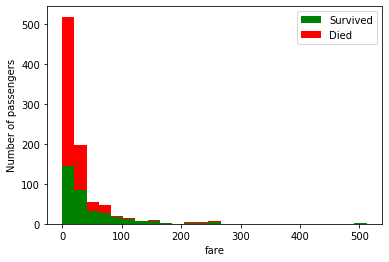

In [99]:
import matplotlib.pyplot as plt
t = t_train_orig
fare_survived =t[t['Survived'] == 1]['Fare'] 
fare_died = t[t['Survived'] == 0]['Fare'] 
plt.hist([fare_survived, fare_died], stacked=True, color = ['g', 'r'], 
         bins = 25, label=['Survived', 'Died'])
plt.xlabel('fare')
plt.ylabel('Number of passengers')
plt.legend()

### Class also improves chance of survival


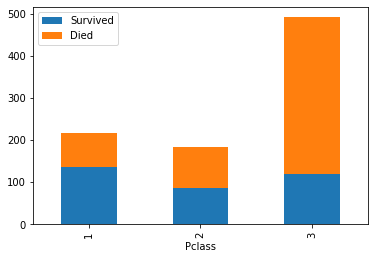

In [100]:
t_train_orig.groupby('Pclass').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true')

### Look for columns with missing values and fill them
Fill NAs in the training data for age, cabin, and embarked

In [103]:
def display_missing(df):    
    for col in df.columns.tolist(): 
        if df[col].isnull().sum() > 0:
            print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')

dfs = [t_train_orig, t_test_orig]

for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Titanic Training Set
Age column missing values: 177
Cabin column missing values: 687
Embarked column missing values: 2


Titanic Test Set
Age column missing values: 86
Fare column missing values: 1
Cabin column missing values: 327




In [149]:
t_train = t_train_orig
median_ages = t_train.groupby('Pclass').median()
t_train['Age'] = t_train.apply(lambda row: median_ages['Age'][row['Pclass']] if np.isnan(row['Age']) else row['Age'], axis=1)
t_train['Cabin'].fillna('U')
import operator
embarked_group_counts = sorted(t_train.groupby('Embarked')['PassengerId'].count().items(), key=operator.itemgetter(1), reverse=True)
# fillNA for Embarked with the most common port code
t_train['Embarked'].fillna(embarked_group_counts[0][0])

0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object

### Sample training data

In [105]:
t_train_orig.sample(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Died
132,133,0,3,"Robins, Mrs. Alexander A (Grace Charity Laury)",female,47.0,1,0,A/5. 3337,14.5000,NaN,S,1
870,871,0,3,"Balkic, Mr. Cerin",male,26.0,0,0,349248,7.8958,NaN,S,1
538,539,0,3,"Risien, Mr. Samuel Beard",male,24.0,0,0,364498,14.5000,NaN,S,1
238,239,0,2,"Pengelly, Mr. Frederick William",male,19.0,0,0,28665,10.5000,NaN,S,1
608,609,1,2,"Laroche, Mrs. Joseph (Juliette Marie Louise La...",female,22.0,1,2,SC/Paris 2123,41.5792,NaN,C,0
447,448,1,1,"Seward, Mr. Frederic Kimber",male,34.0,0,0,113794,26.5500,NaN,S,0
173,174,0,3,"Sivola, Mr. Antti Wilhelm",male,21.0,0,0,STON/O 2. 3101280,7.9250,NaN,S,1
849,850,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,37.0,1,0,17453,89.1042,C92,C,0


## Feature exploration

Here are some initial ideas:
* Pclass (1 > 2 > 3)
* Fare ($$ > $)
* Sex (female > male)
* CabinPresent (1 > 0)
* Is child over 12 (1 > 0)


In [154]:
import math
from sklearn import preprocessing

t_train = t_train_orig

# sex to numeric
t_train['SexNumeric'] = np.where(t_train['Sex'] == "male", 0, 1)

# fill in missing fare with median fare for passengers in the same class
median_fares = t_train.groupby('Pclass')['Fare'].median()
def fare_for_class(row):
    return median_fares[row['Pclass']] if row['Fare'] == 0 else row['Fare']
t_train['FareAdjusted'] = t_train.apply(fare_for_class,axis=1)

# TODO: update AgeAdjusted to take into account title to refine the likely age, so that a child with
# missing age doesn't get classified as an adult.. a male child should be much more likely to survive
# so that should help

# extract titles
#get_index = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y][0]

t_train['Title'] = t_train_orig['Name'].map(lambda name: [title for title in name.split(' ') if '.' in title][0])
#all_titles = t_train['Title'].unique()
titles_esteemed_first = {
    'Countess.': 17,
    'Lady.': 16,
    'Rev.': 15,
    'Jonkheer.': 14,
    'Master.': 13,
    'Major.' : 12,
    'Don.': 11,
    'Dr.' : 10,
    'Col.': 9,
    'Capt.': 8,
    'Mlle.': 7,
    'Miss.': 6,
    'Ms.': 5,
    'Mrs.': 4,
    'Mme.': 3,
    'Sir.': 2,
    'Mr.': 1
}

t_train['TitleNumeric'] = t_train['Title'].map(lambda title: titles_esteemed_first[title])

feature_cols = ['FareAdjusted', 'Pclass', 'SexNumeric', 'TitleNumeric']
t_train[feature_cols].sample(12)

,FareAdjusted,Pclass,SexNumeric,TitleNumeric
423,14.4000,3,1,4
878,7.8958,3,0,1
457,51.8625,1,1,4
246,7.7750,3,1,6
87,8.0500,3,0,1
467,26.5500,1,0,1
35,52.0000,1,0,1
296,7.2292,3,0,1
686,39.6875,3,0,1
38,18.0000,3,1,6


## Using a Decision Tree Classifier

In [107]:
import pandas as pd

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

X_dt = t_train[feature_cols]
y_dt = t_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X_dt, y_dt, test_size=0.3, random_state=1) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8208955223880597


## Using a Random Forrest Classifier

### Additional features

In [163]:
t_train['Deck'] = \
    t_train['Cabin'].map(lambda cabin: cabin[0] if (type(cabin) == str) else "U")

# simply having s cabin assigned increases chances of survival
t_train['CabinGoodNumeric'] = \
t_train['Deck'].map(lambda letter: 1 if (letter in "BDEG") else 0)


### correlate deck with survival rate for assigned cabins

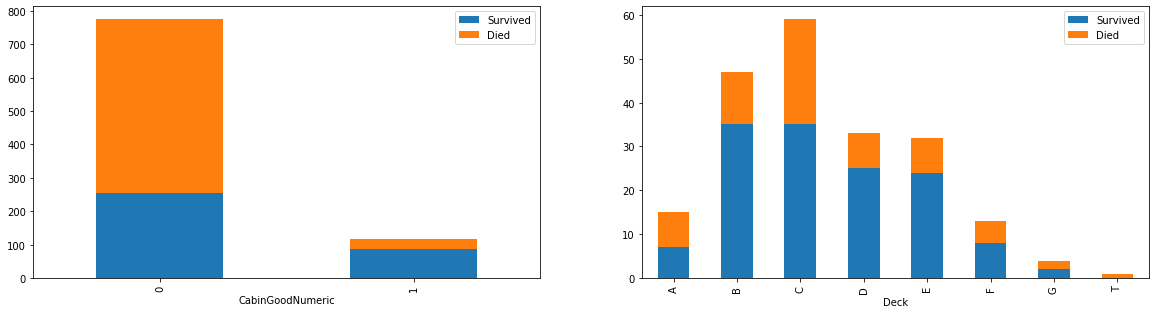

In [165]:
# correlate deck with survival rate for assigned cabins
import string
f, (ax1, ax2) = plt.subplots(1, 2, False, figsize=(20,5))
t_train_orig[t_train_orig['Deck'] != 'U'].groupby('Deck').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true', ax=ax2)
t_train_orig.groupby('CabinGoodNumeric').agg('sum')[['Survived', 'Died']].plot(kind='bar', stacked='true', ax=ax1)

# CabinGoodNumeric doesn't yet seem to inprove things.. can it be made to be useful?
# why is it not a very important feature according to random forrest.. is it because most people don't have a cabin?

In [153]:
t_train_corr = t_train_orig.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
t_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
groups = t_train_corr[(0.1 < t_train_corr["Correlation Coefficient"]) & (t_train_corr["Correlation Coefficient"] < .85)].groupby('Feature 1')
groups.get_group('Survived')

,Feature 1,Feature 2,Correlation Coefficient
20,Survived,SexNumeric,0.543351
33,Survived,TitleNumeric,0.364918
39,Survived,Pclass,0.338481
48,Survived,CabinGoodNumeric,0.284435
57,Survived,Fare,0.257307
60,Survived,FareAdjusted,0.250635


### Using OneHotEncoding

In [306]:
feature_cols_ohe = ['FareAdjusted', 'Pclass', 'SexNumeric', 'Title', 'Age', 'Deck']
X_ohe = t_train[feature_cols_ohe]

X_ohe = pd.concat([X_ohe,pd.get_dummies(X_ohe['Title'], prefix='Title')],axis=1).drop('Title', axis=1)
X_ohe = pd.concat([X_ohe,pd.get_dummies(X_ohe['Deck'], prefix='Deck')],axis=1).drop('Deck', axis=1)

# drop features that got a 0.0000 importance 
X_ohe = X_ohe.drop(['Title_Countess.', 'Deck_T', 'Title_Ms.', 'Title_Sir.', 'Title_Don.', 'Title_Capt.', 
                    'Title_Col.', 'Title_Mlle.', 'Title_Major.', 'Title_Lady.', 'Title_Jonkheer.', 
                    'Title_Mme.', 'Deck_T'] , axis=1)
X_ohe

,FareAdjusted,Pclass,SexNumeric,Age,Title_Dr.,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rev.,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_U
0,7.2500,3,0,22.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,71.2833,1,1,38.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,7.9250,3,1,26.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,53.1000,1,1,35.0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,8.0500,3,0,35.0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,13.0000,2,0,27.0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
887,30.0000,1,1,19.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
888,23.4500,3,1,24.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
889,30.0000,1,0,26.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0


### apply Random Forrest Classifier to the features


In [359]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

X_re = X_ohe
y_re = t_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X_re, y_re, test_size=0.25, random_state=42)

rfc = RandomForestClassifier(n_estimators=100,
                             min_samples_split=3, min_samples_leaf=3, max_depth=15,
                             max_features=0.85, n_jobs=-1)

cv_results = cross_validate(rfc, X_re,y_re, return_train_score=True, return_estimator=True, cv=5)


In [360]:
print(f'Fit   Time:  {cv_results["fit_time"]}')
print(f'Score Time:  {cv_results["score_time"]}\n')
print(f'Train Score: {cv_results["train_score"]}')
print(f'Test Score:  {cv_results["test_score"]}\n')

from IPython.lib.pretty import pretty

estimators = list(cv_results['estimator'])

for estimator in estimators:
    print("============")
    print(pd.DataFrame(estimator.feature_importances_,
                        index = X_re.columns,
                        columns=['importance']).sort_values('importance',ascending=False))
    

Fit   Time:  [1.81674528 1.68478918 1.72295928 1.77509284 1.75710678]
Score Time:  [0.11378288 0.11243391 0.11310673 0.11427212 0.11012197]

Train Score: [0.9002809  0.91853933 0.89761571 0.90322581 0.90056022]
Test Score:  [0.82681564 0.81005587 0.88764045 0.82022472 0.85310734]

               importance
Title_Mr.        0.292942
FareAdjusted     0.227083
Age              0.155169
Pclass           0.123908
SexNumeric       0.118286
Deck_U           0.026828
Deck_E           0.011877
Title_Master.    0.008571
Title_Rev.       0.007066
Title_Mrs.       0.006677
Deck_C           0.005778
Title_Miss.      0.004221
Deck_B           0.004141
Deck_D           0.002879
Title_Dr.        0.002560
Deck_A           0.002013
Deck_F           0.000000
Deck_G           0.000000
               importance
Title_Mr.        0.278445
FareAdjusted     0.234039
Age              0.157411
SexNumeric       0.119183
Pclass           0.117375
Deck_U           0.039119
Title_Rev.       0.013501
Title_Master.   

In [365]:
from sklearn.model_selection import GridSearchCV

X_cv = X_ohe
y_cv = t_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size=0.20, random_state=42)

rfc = RandomForestClassifier(min_samples_split=3, min_samples_leaf=3,
                             max_features=0.85, n_jobs=-1)

param_grid = {
    'max_depth': [1, 2, 4, 6, 8, 10, 15],
    'n_estimators': [10, 50, 100, 250]}

search = GridSearchCV(rfc, param_grid, cv=5)

search.fit(X_cv, y_cv)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=0.85,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=3,
                                              min_samples_split=3,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid='wa

In [367]:
cv_resultsDF = pd.DataFrame(search.cv_results_)
cv_resultsDF.sort_values(by=['rank_test_score'])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
27,2.120427,0.052114,0.109969,0.001866,15,250,"{'max_depth': 15, 'n_estimators': 250}",0.843575,0.815642,0.887640,0.820225,0.864407,0.846240,0.027068,1
23,2.392598,0.071597,0.111798,0.001374,10,250,"{'max_depth': 10, 'n_estimators': 250}",0.843575,0.810056,0.893258,0.808989,0.858757,0.842873,0.031672,2
22,2.274425,0.095976,0.113092,0.001524,10,100,"{'max_depth': 10, 'n_estimators': 100}",0.843575,0.810056,0.887640,0.814607,0.858757,0.842873,0.028750,2
18,2.175388,0.058118,0.110422,0.001814,8,100,"{'max_depth': 8, 'n_estimators': 100}",0.837989,0.815642,0.876404,0.814607,0.870056,0.842873,0.026168,2
25,2.046369,0.118414,0.110960,0.001641,15,50,"{'max_depth': 15, 'n_estimators': 50}",0.826816,0.804469,0.893258,0.820225,0.864407,0.841751,0.032382,5
21,2.362281,0.128880,0.112637,0.001973,10,50,"{'max_depth': 10, 'n_estimators': 50}",0.843575,0.810056,0.882022,0.820225,0.853107,0.841751,0.025390,5
17,2.188984,0.068119,0.111966,0.001592,8,50,"{'max_depth': 8, 'n_estimators': 50}",0.826816,0.810056,0.882022,0.808989,0.875706,0.840629,0.031825,7
26,1.946124,0.058836,0.181375,0.138385,15,100,"{'max_depth': 15, 'n_estimators': 100}",0.826816,0.810056,0.887640,0.814607,0.864407,0.840629,0.030253,7
19,2.486188,0.160407,0.111920,0.001652,8,250,"{'max_depth': 8, 'n_estimators': 250}",0.832402,0.804469,0.876404,0.814607,0.864407,0.838384,0.027830,9
13,2.478653,0.093497,0.113016,0.002884,6,50,"{'max_depth': 6, 'n_estimators': 50}",0.843575,0.804469,0.876404,0.808989,0.847458,0.836139,0.026631,10


## Using Logistic Regression

In [115]:
from sklearn.linear_model import LogisticRegression

feature_cols = ['FareAdjusted', 'Pclass', 'SexNumeric', 'TitleNumeric']

X_lr = t_train[feature_cols]
y_lr = t_train.Survived
X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=0.25, random_state=1) # 70% training and 30% test

lr = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial').fit(X_train, y_train)
prob = lr.predict_proba(X_lr)

print(f'probabilty (count = {len(prob)}\n{prob}\n')
print(f'score: {clf.score(X_test, y_test)}')


probabilty (count = 891
[[0.93191471 0.06808529]
 [0.11022188 0.88977812]
 [0.40116983 0.59883017]
 ...
 [0.40131613 0.59868387]
 [0.64606079 0.35393921]
 [0.93191595 0.06808405]]

score: 0.8385650224215246


## Using K-Nearest Neighbors
because.. why not?

In [112]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[118  10]
 [ 37  58]]
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       128
           1       0.85      0.61      0.71        95

    accuracy                           0.79       223
   macro avg       0.81      0.77      0.77       223
weighted avg       0.80      0.79      0.78       223

